# Hierarchical Clustering


## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, load_iris, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Set random seed and plotting style
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Generate and Visualize Synthetic Data

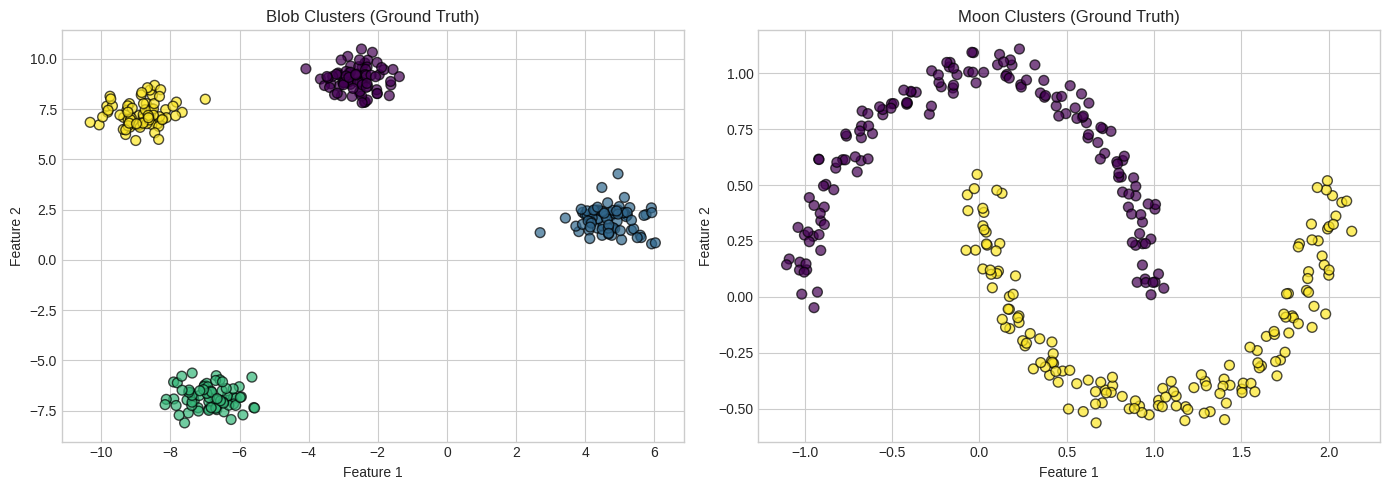

Blob dataset shape: (300, 2)
Moon dataset shape: (300, 2)


In [2]:
# Generate synthetic clustered data
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.6,
                               n_features=2, random_state=42)

# Generate moon-shaped data (non-globular clusters)
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)

# Visualize both datasets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis',
                alpha=0.7, edgecolors='k', s=50)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Blob Clusters (Ground Truth)')

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis',
                alpha=0.7, edgecolors='k', s=50)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Moon Clusters (Ground Truth)')

plt.tight_layout()
plt.show()

print(f"Blob dataset shape: {X_blobs.shape}")
print(f"Moon dataset shape: {X_moons.shape}")

## 3. Understanding Dendrograms

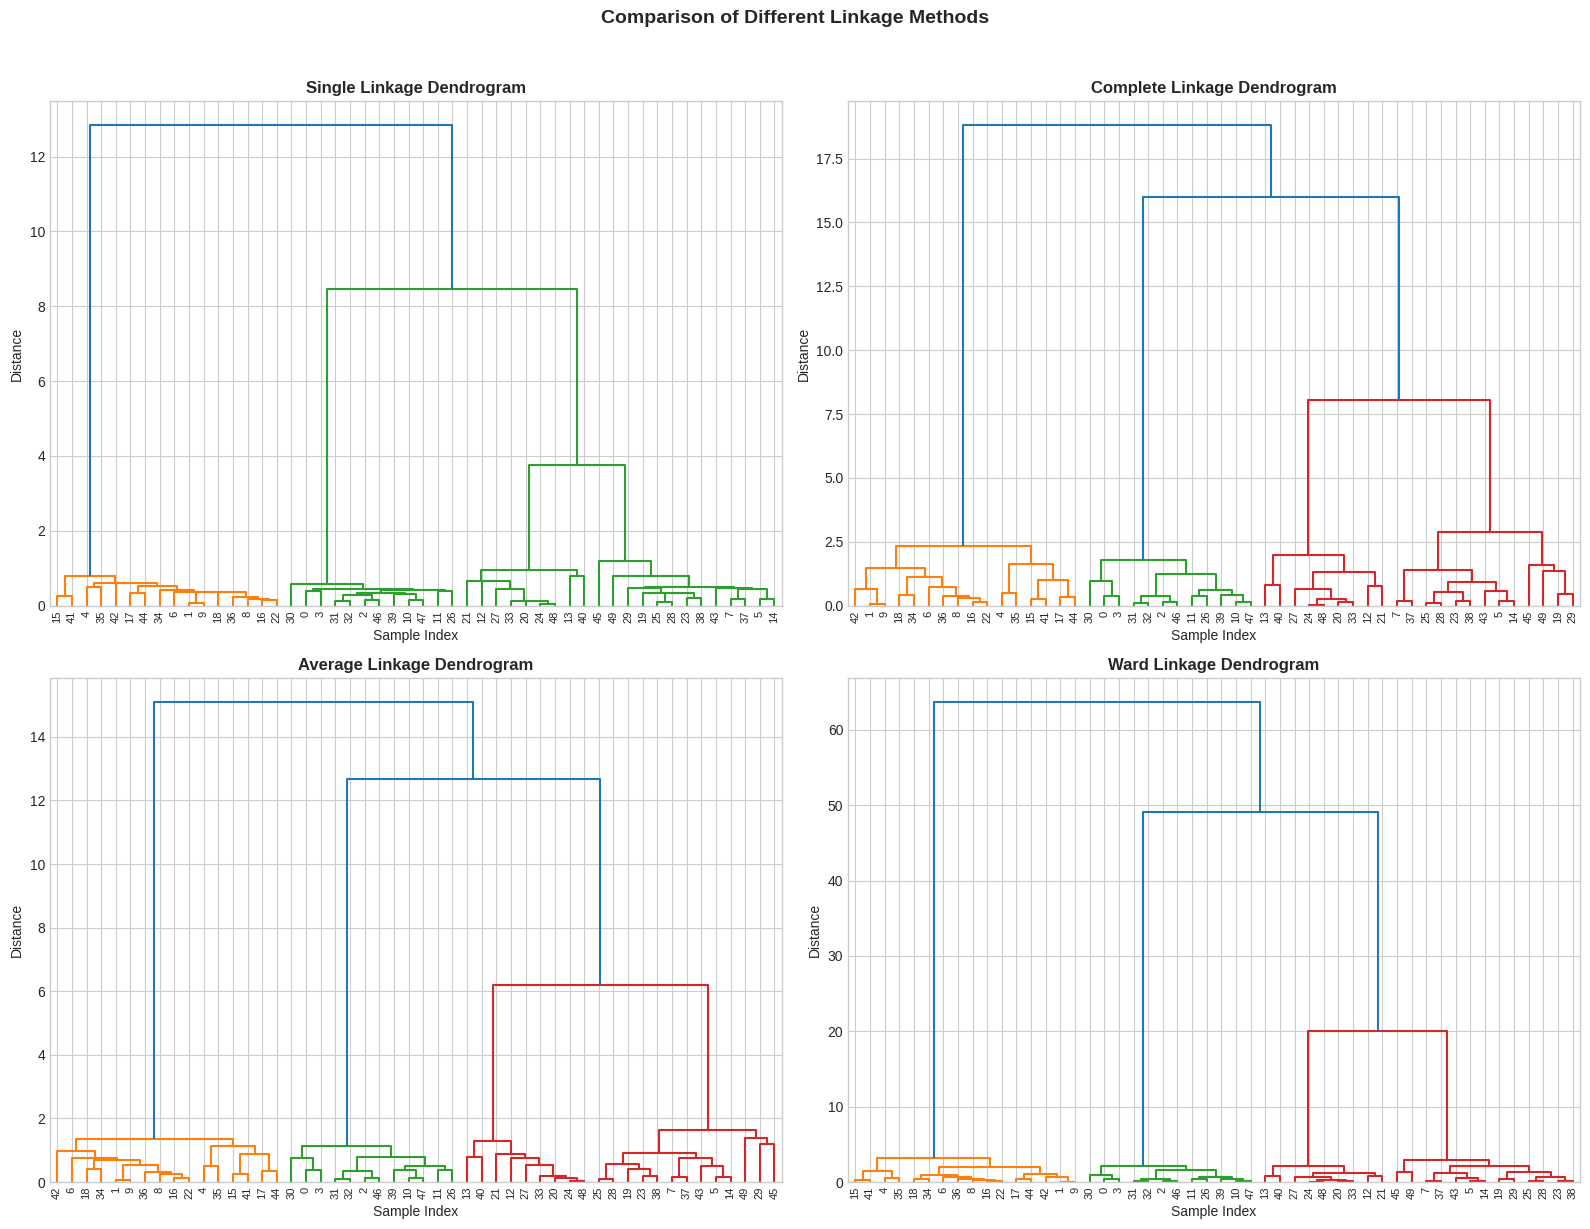

In [3]:
# Create a smaller subset for clear dendrogram visualization
np.random.seed(42)
sample_indices = np.random.choice(len(X_blobs), 50, replace=False)
X_sample = X_blobs[sample_indices]

# Calculate linkage matrix using different methods
linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, method in enumerate(linkage_methods):
    Z = linkage(X_sample, method=method)
    dendrogram(Z, ax=axes[idx], leaf_rotation=90, leaf_font_size=8)
    axes[idx].set_title(f'{method.capitalize()} Linkage Dendrogram', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Distance')

plt.suptitle('Comparison of Different Linkage Methods', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Cophenetic Correlation Coefficient

The cophenetic correlation coefficient measures how well the dendrogram preserves the pairwise distances between data points. A value close to 1 indicates good preservation.

In [4]:
# Calculate cophenetic correlation for each linkage method
print("Cophenetic Correlation Coefficients:")
print("="*50)

coph_results = {}
for method in linkage_methods:
    Z = linkage(X_blobs, method=method)
    c, coph_dists = cophenet(Z, pdist(X_blobs))
    coph_results[method] = c
    print(f"{method.capitalize()} Linkage: {c:.4f}")

print("\nHigher values indicate better preservation of original distances.")
print(f"Best method: {max(coph_results, key=coph_results.get).capitalize()} Linkage")

Cophenetic Correlation Coefficients:
Single Linkage: 0.9599
Complete Linkage: 0.9645
Average Linkage: 0.9693
Ward Linkage: 0.9686

Higher values indicate better preservation of original distances.
Best method: Average Linkage


## 5. Agglomerative Clustering with Sklearn

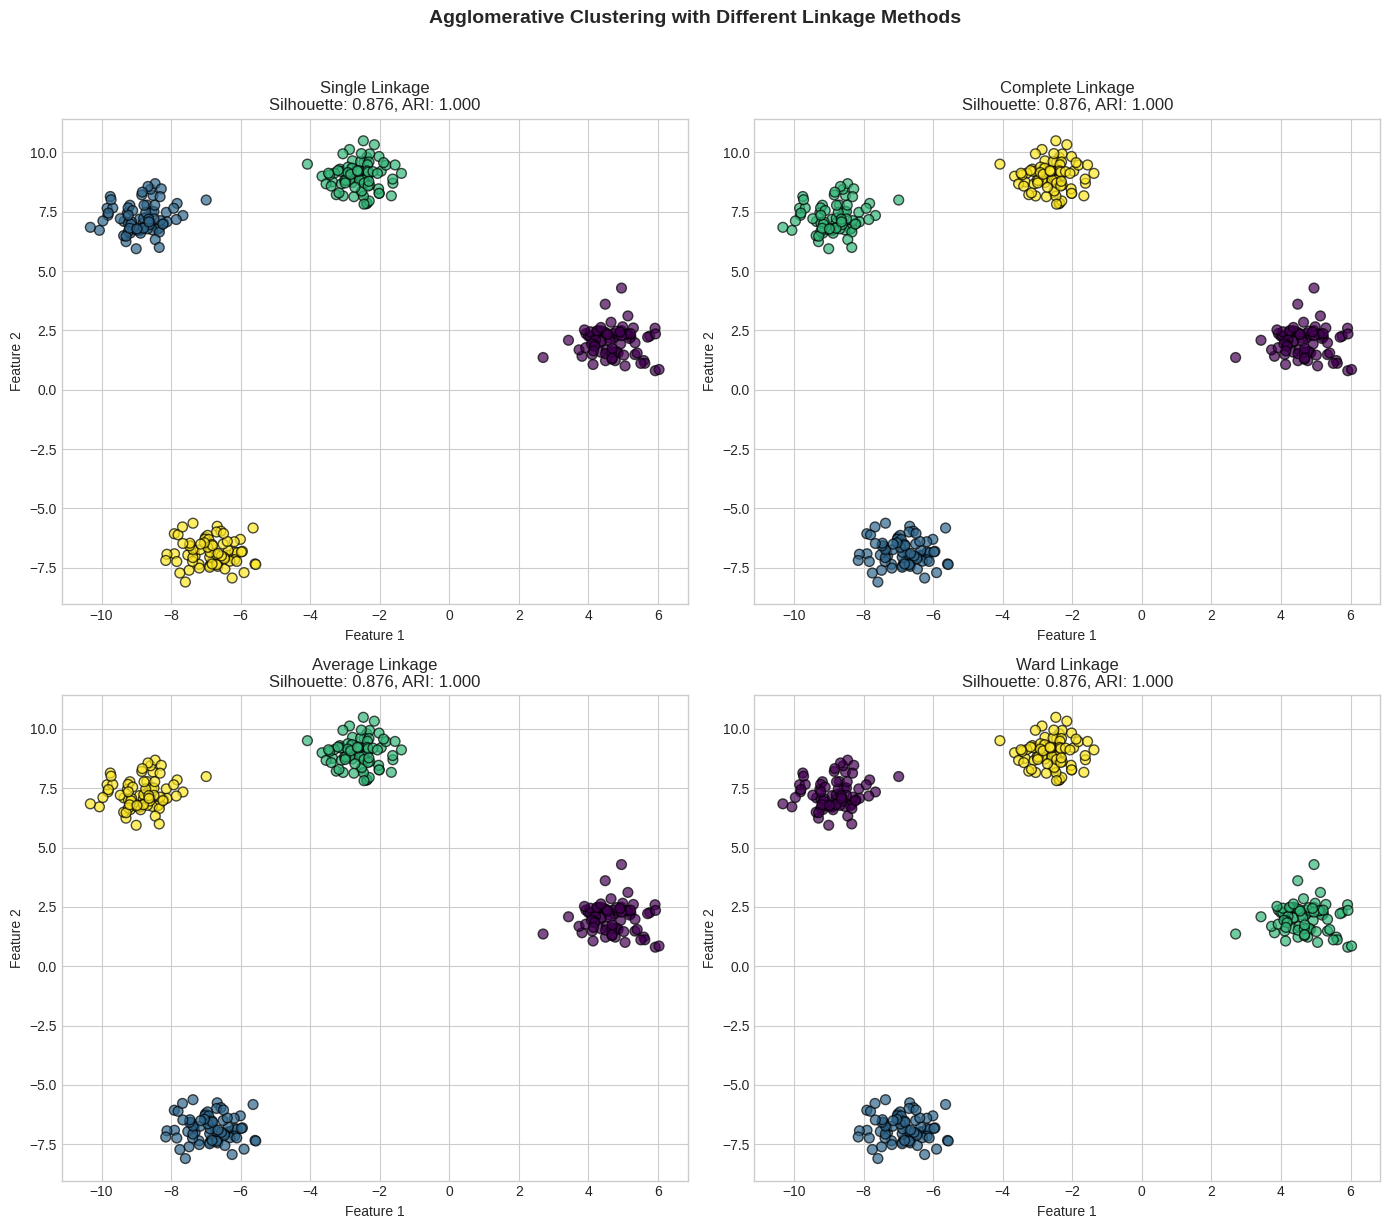

In [5]:
# Apply Agglomerative Clustering with different linkage methods
n_clusters = 4

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

results = {}

for idx, method in enumerate(linkage_methods):
    # Ward linkage requires Euclidean distance
    if method == 'ward':
        agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
    else:
        agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)

    labels = agg_cluster.fit_predict(X_blobs)

    # Calculate metrics
    sil_score = silhouette_score(X_blobs, labels)
    ch_score = calinski_harabasz_score(X_blobs, labels)
    db_score = davies_bouldin_score(X_blobs, labels)
    ari = adjusted_rand_score(y_blobs, labels)

    results[method] = {
        'labels': labels,
        'silhouette': sil_score,
        'calinski_harabasz': ch_score,
        'davies_bouldin': db_score,
        'adjusted_rand': ari
    }

    # Plot
    scatter = axes[idx].scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels,
                                 cmap='viridis', alpha=0.7, edgecolors='k', s=50)
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')
    axes[idx].set_title(f'{method.capitalize()} Linkage\nSilhouette: {sil_score:.3f}, ARI: {ari:.3f}')

plt.suptitle('Agglomerative Clustering with Different Linkage Methods',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [6]:
# Display metrics comparison
metrics_df = pd.DataFrame({
    'Linkage Method': [m.capitalize() for m in linkage_methods],
    'Silhouette Score': [results[m]['silhouette'] for m in linkage_methods],
    'Calinski-Harabasz': [results[m]['calinski_harabasz'] for m in linkage_methods],
    'Davies-Bouldin': [results[m]['davies_bouldin'] for m in linkage_methods],
    'Adjusted Rand Index': [results[m]['adjusted_rand'] for m in linkage_methods]
})

print("\nClustering Quality Metrics Comparison:")
print("="*80)
print(metrics_df.to_string(index=False))
print("\n" + "="*80)
print("\nMetric Interpretation:")
print("• Silhouette Score: Higher is better (range: -1 to 1)")
print("• Calinski-Harabasz: Higher is better")
print("• Davies-Bouldin: Lower is better")
print("• Adjusted Rand Index: Higher is better (1.0 = perfect match with ground truth)")


Clustering Quality Metrics Comparison:
Linkage Method  Silhouette Score  Calinski-Harabasz  Davies-Bouldin  Adjusted Rand Index
        Single          0.875647        9411.506666        0.173674                  1.0
      Complete          0.875647        9411.506666        0.173674                  1.0
       Average          0.875647        9411.506666        0.173674                  1.0
          Ward          0.875647        9411.506666        0.173674                  1.0


Metric Interpretation:
• Silhouette Score: Higher is better (range: -1 to 1)
• Calinski-Harabasz: Higher is better
• Davies-Bouldin: Lower is better
• Adjusted Rand Index: Higher is better (1.0 = perfect match with ground truth)


## 6. Hierarchical Clustering on Moon-Shaped Data

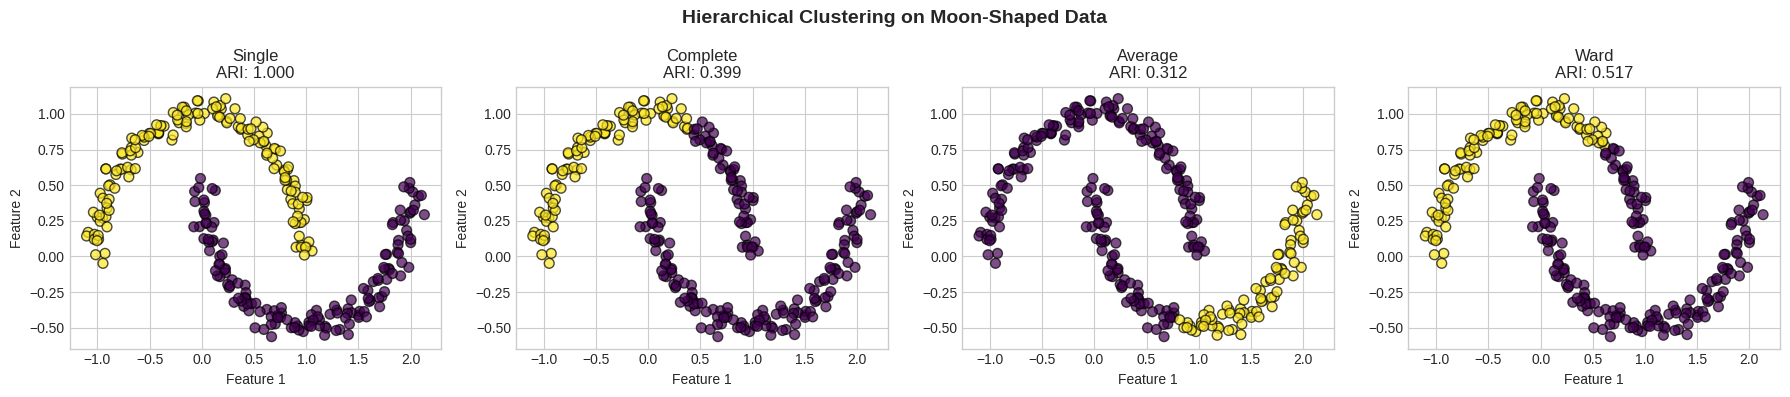


Note: Single linkage performs best on non-globular clusters
because it can detect elongated cluster shapes.


In [7]:
# Compare different linkage methods on non-globular data
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

moon_results = {}

for idx, method in enumerate(linkage_methods):
    agg_cluster = AgglomerativeClustering(n_clusters=2, linkage=method)
    labels = agg_cluster.fit_predict(X_moons)

    ari = adjusted_rand_score(y_moons, labels)
    sil = silhouette_score(X_moons, labels)
    moon_results[method] = {'ari': ari, 'silhouette': sil}

    axes[idx].scatter(X_moons[:, 0], X_moons[:, 1], c=labels,
                      cmap='viridis', alpha=0.7, edgecolors='k', s=50)
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')
    axes[idx].set_title(f'{method.capitalize()}\nARI: {ari:.3f}')

plt.suptitle('Hierarchical Clustering on Moon-Shaped Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNote: Single linkage performs best on non-globular clusters")
print("because it can detect elongated cluster shapes.")

## 7. Cutting the Dendrogram at Different Heights

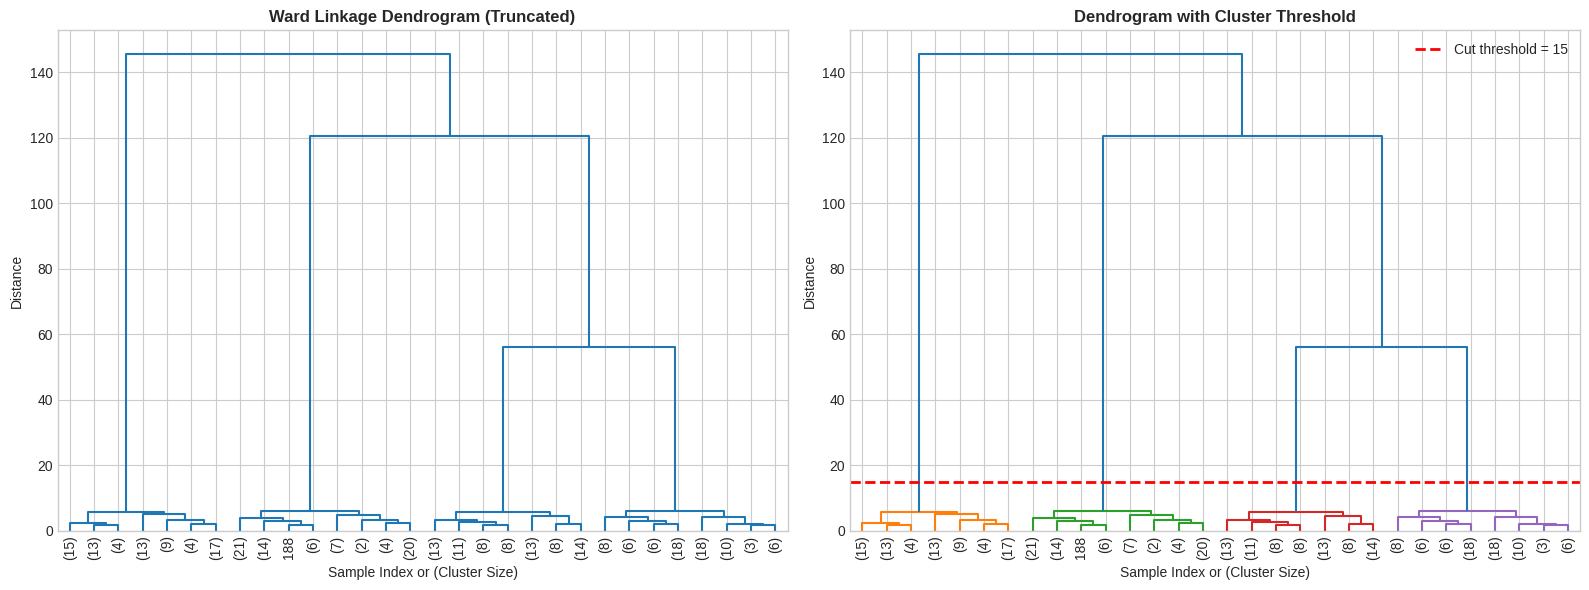

In [8]:
# Create linkage matrix for full blob dataset
Z_ward = linkage(X_blobs, method='ward')

# Plot dendrogram with color threshold
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full dendrogram
dendrogram(Z_ward, ax=axes[0], truncate_mode='lastp', p=30,
           leaf_rotation=90, leaf_font_size=10, color_threshold=0)
axes[0].set_title('Ward Linkage Dendrogram (Truncated)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sample Index or (Cluster Size)')
axes[0].set_ylabel('Distance')

# Dendrogram with color threshold to show 4 clusters
threshold = 15
dendrogram(Z_ward, ax=axes[1], truncate_mode='lastp', p=30,
           leaf_rotation=90, leaf_font_size=10, color_threshold=threshold)
axes[1].axhline(y=threshold, color='red', linestyle='--', linewidth=2,
                label=f'Cut threshold = {threshold}')
axes[1].set_title('Dendrogram with Cluster Threshold', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sample Index or (Cluster Size)')
axes[1].set_ylabel('Distance')
axes[1].legend()

plt.tight_layout()
plt.show()

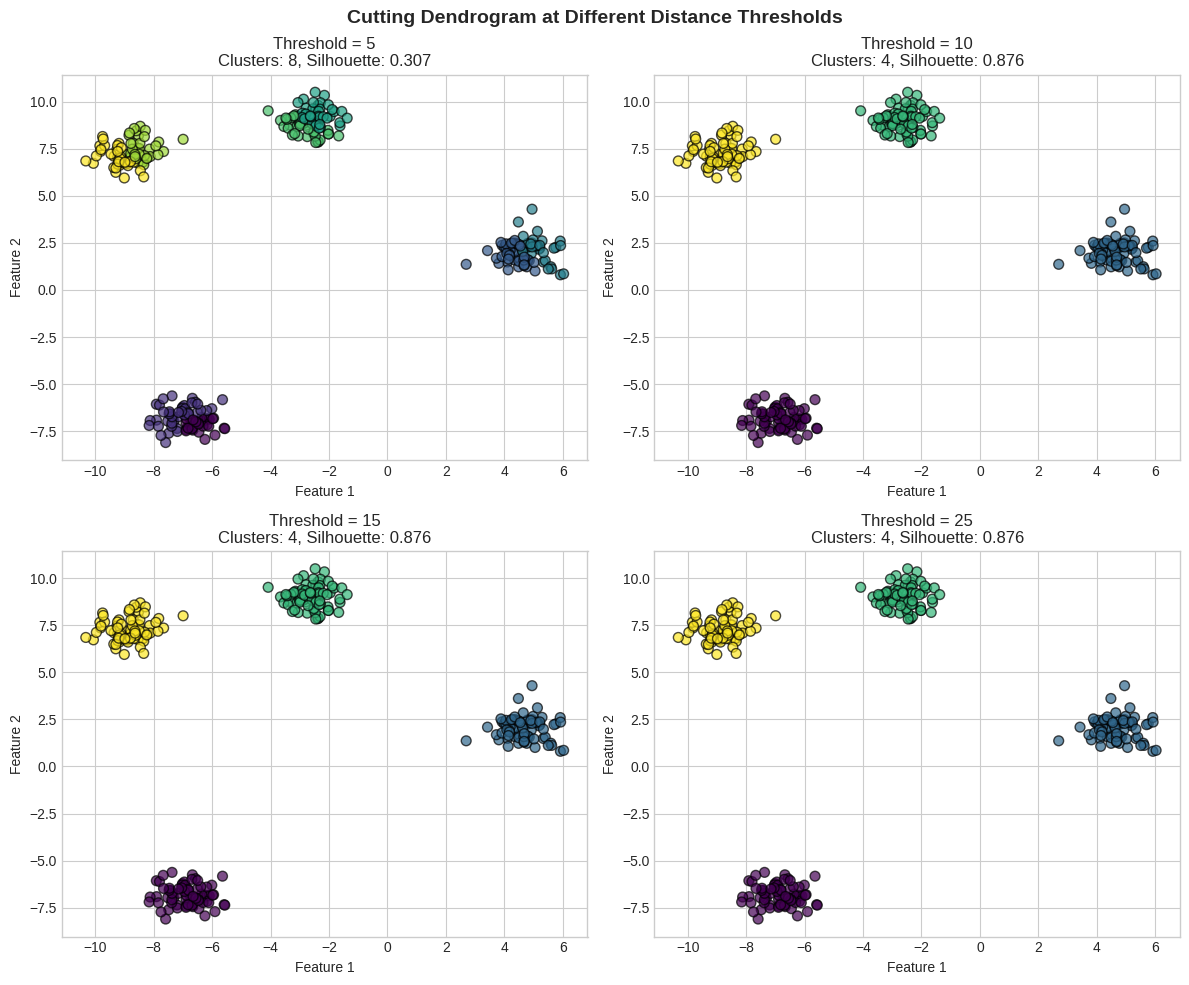

In [9]:
# Cut dendrogram at different thresholds
thresholds = [5, 10, 15, 25]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, thresh in enumerate(thresholds):
    labels = fcluster(Z_ward, t=thresh, criterion='distance')
    n_clusters_found = len(np.unique(labels))

    if n_clusters_found > 1:
        sil = silhouette_score(X_blobs, labels)
    else:
        sil = 0

    scatter = axes[idx].scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels,
                                 cmap='viridis', alpha=0.7, edgecolors='k', s=50)
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')
    axes[idx].set_title(f'Threshold = {thresh}\nClusters: {n_clusters_found}, Silhouette: {sil:.3f}')

plt.suptitle('Cutting Dendrogram at Different Distance Thresholds',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Finding Optimal Number of Clusters

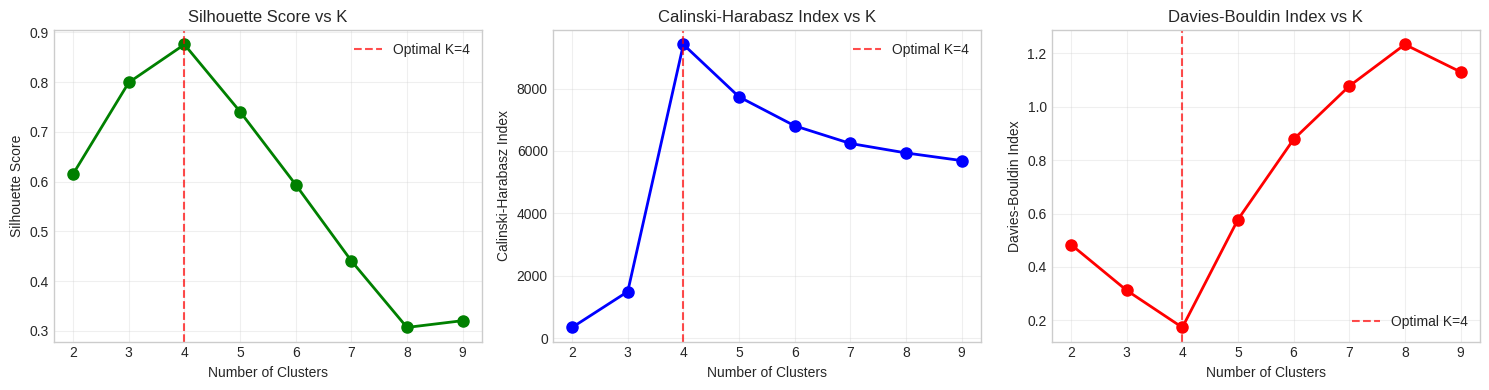


Optimal K by Silhouette Score: 4
Optimal K by Calinski-Harabasz Index: 4
Optimal K by Davies-Bouldin Index: 4


In [10]:
# Calculate metrics for different number of clusters
k_range = range(2, 10)
silhouette_scores = []
ch_scores = []
db_scores = []

for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_blobs)

    silhouette_scores.append(silhouette_score(X_blobs, labels))
    ch_scores.append(calinski_harabasz_score(X_blobs, labels))
    db_scores.append(davies_bouldin_score(X_blobs, labels))

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs K')
axes[0].axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Optimal K=4')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, ch_scores, 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index vs K')
axes[1].axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Optimal K=4')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(k_range, db_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index vs K')
axes[2].axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Optimal K=4')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal K
optimal_k_sil = list(k_range)[np.argmax(silhouette_scores)]
optimal_k_ch = list(k_range)[np.argmax(ch_scores)]
optimal_k_db = list(k_range)[np.argmin(db_scores)]

print(f"\nOptimal K by Silhouette Score: {optimal_k_sil}")
print(f"Optimal K by Calinski-Harabasz Index: {optimal_k_ch}")
print(f"Optimal K by Davies-Bouldin Index: {optimal_k_db}")

## 9. Real Dataset: Iris Clustering

In [11]:
# Load and prepare Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names

# Standardize features
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

print(f"Iris dataset shape: {X_iris.shape}")
print(f"Features: {feature_names}")
print(f"Number of species: {len(np.unique(y_iris))}")

Iris dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of species: 3


In [12]:
# Apply hierarchical clustering to Iris dataset
agg_iris = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_iris = agg_iris.fit_predict(X_iris_scaled)

# Calculate metrics
sil_iris = silhouette_score(X_iris_scaled, labels_iris)
ari_iris = adjusted_rand_score(y_iris, labels_iris)
nmi_iris = normalized_mutual_info_score(y_iris, labels_iris)

print("Iris Clustering Metrics:")
print(f"  Silhouette Score: {sil_iris:.4f}")
print(f"  Adjusted Rand Index: {ari_iris:.4f}")
print(f"  Normalized Mutual Information: {nmi_iris:.4f}")

Iris Clustering Metrics:
  Silhouette Score: 0.4467
  Adjusted Rand Index: 0.6153
  Normalized Mutual Information: 0.6755


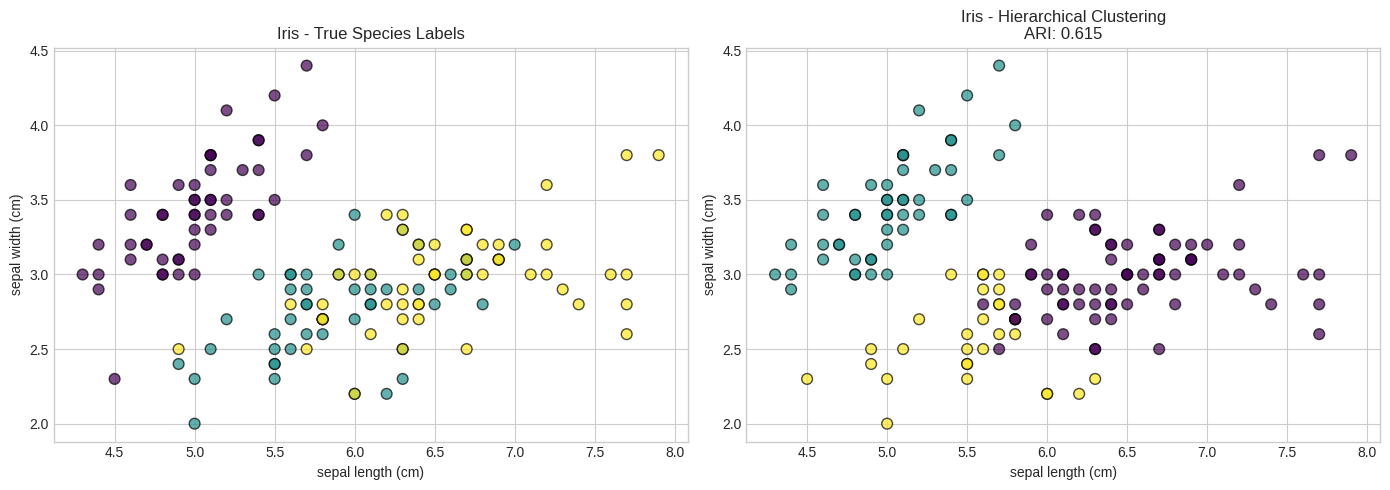

In [13]:
# Visualize Iris clustering
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True labels
scatter1 = axes[0].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris,
                           cmap='viridis', alpha=0.7, edgecolors='k', s=60)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].set_title('Iris - True Species Labels')

# Hierarchical clustering labels
scatter2 = axes[1].scatter(X_iris[:, 0], X_iris[:, 1], c=labels_iris,
                           cmap='viridis', alpha=0.7, edgecolors='k', s=60)
axes[1].set_xlabel(feature_names[0])
axes[1].set_ylabel(feature_names[1])
axes[1].set_title(f'Iris - Hierarchical Clustering\nARI: {ari_iris:.3f}')

plt.tight_layout()
plt.show()

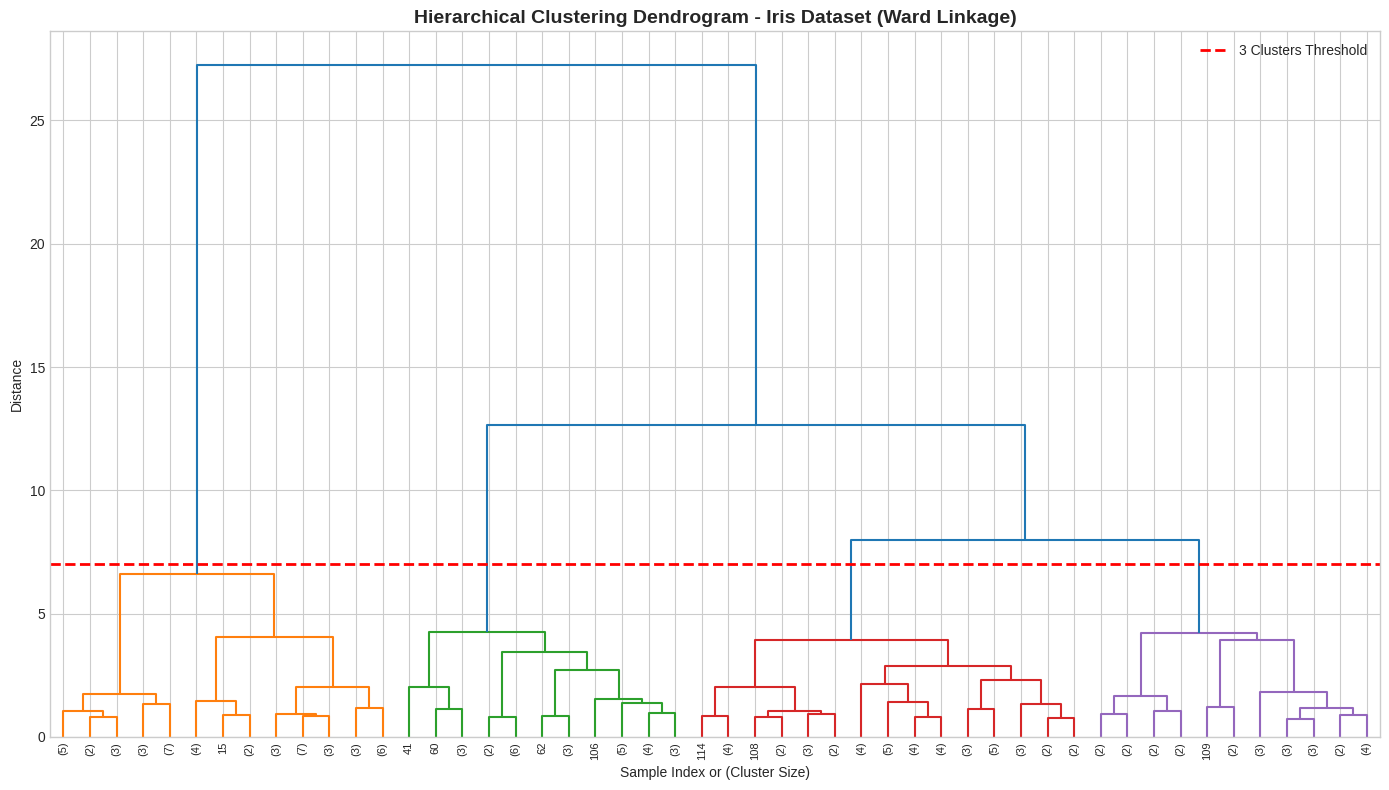

In [14]:
# Create dendrogram for Iris dataset
Z_iris = linkage(X_iris_scaled, method='ward')

plt.figure(figsize=(14, 8))
dendrogram(Z_iris, truncate_mode='lastp', p=50,
           leaf_rotation=90, leaf_font_size=8,
           color_threshold=7)
plt.axhline(y=7, color='red', linestyle='--', linewidth=2, label='3 Clusters Threshold')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram - Iris Dataset (Ward Linkage)',
          fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Heatmap with Hierarchical Clustering

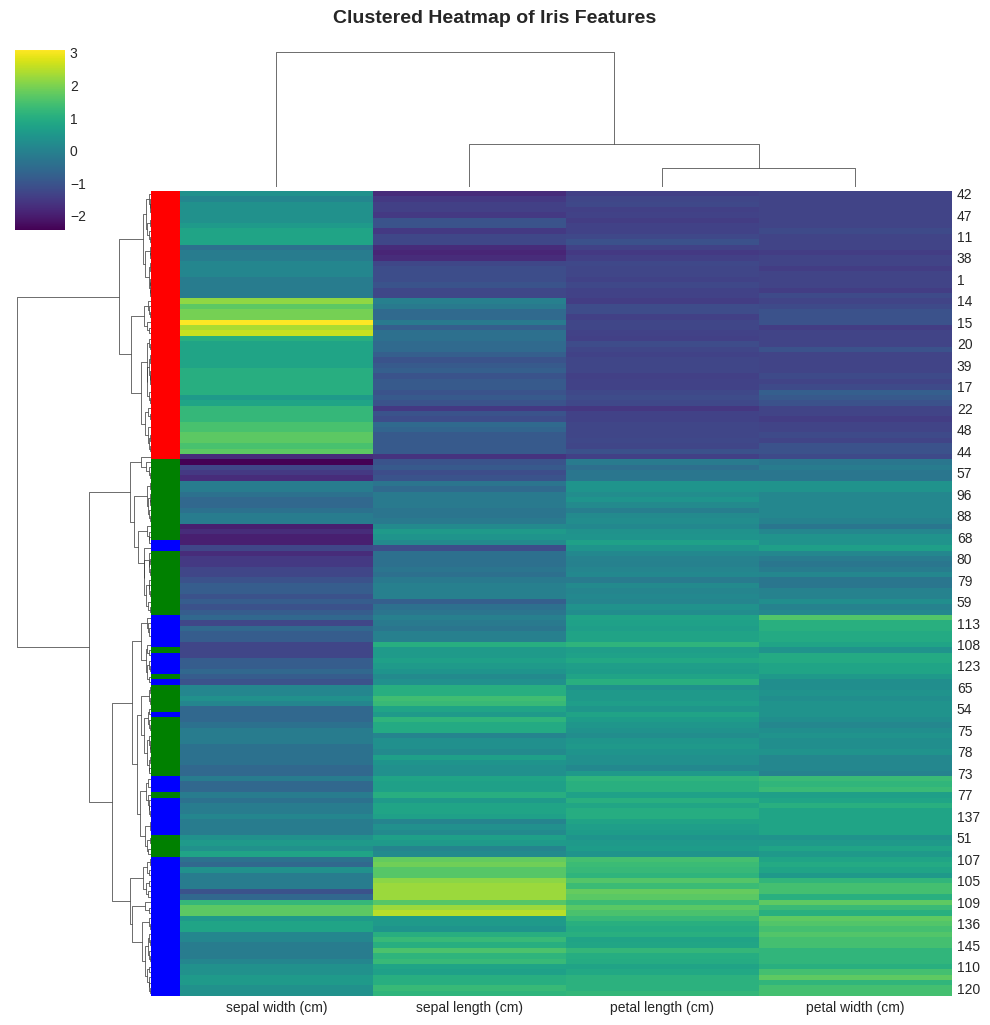


Row colors indicate true species: Red=Setosa, Green=Versicolor, Blue=Virginica


In [15]:
# Create a clustered heatmap using seaborn
iris_df = pd.DataFrame(X_iris_scaled, columns=feature_names)
iris_df['Species'] = iris.target_names[y_iris]

# Create clustermap
g = sns.clustermap(iris_df.drop('Species', axis=1),
                   method='ward',
                   cmap='viridis',
                   standard_scale=None,
                   figsize=(10, 10),
                   row_colors=pd.Series(y_iris).map({0: 'red', 1: 'green', 2: 'blue'}),
                   dendrogram_ratio=(0.15, 0.15))

g.fig.suptitle('Clustered Heatmap of Iris Features', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\nRow colors indicate true species: Red=Setosa, Green=Versicolor, Blue=Virginica")

## 11. Comparison: Hierarchical vs K-Means

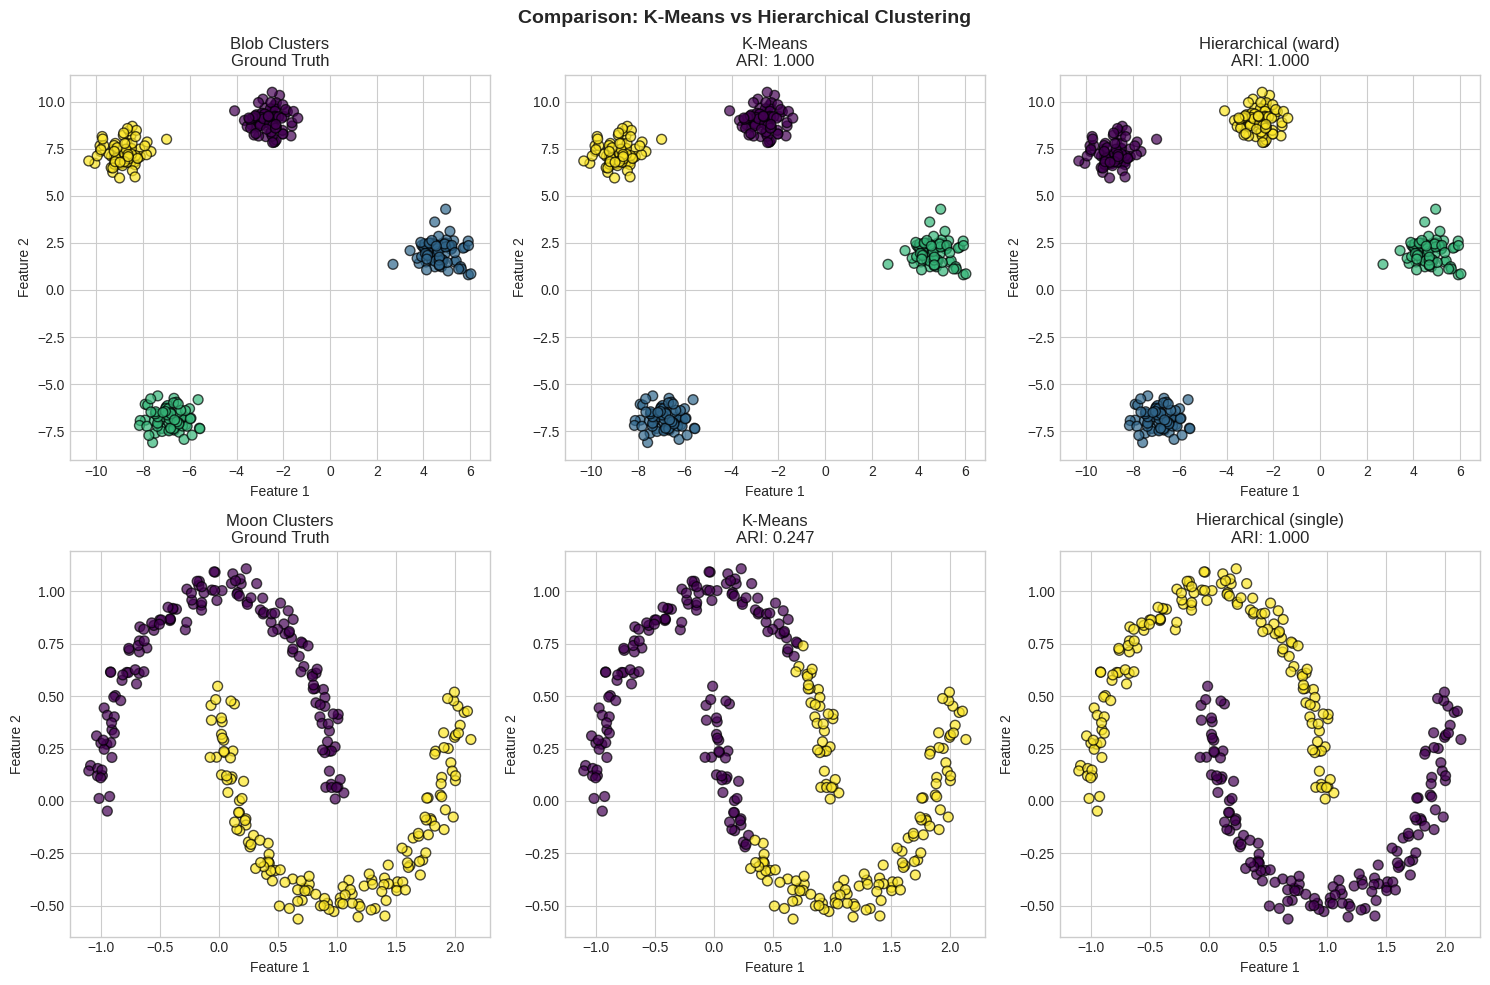


Key Observations:
• K-Means works well on globular clusters (blobs)
• Hierarchical clustering with single linkage handles non-globular shapes (moons)
• Ward linkage works similarly to K-Means for compact clusters


In [16]:
from sklearn.cluster import KMeans

# Compare hierarchical clustering with K-Means on both datasets
datasets = [
    (X_blobs, y_blobs, 'Blob Clusters', 4),
    (X_moons, y_moons, 'Moon Clusters', 2)
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for row, (X, y_true, name, n_clusters) in enumerate(datasets):
    # Ground truth
    axes[row, 0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis',
                         alpha=0.7, edgecolors='k', s=50)
    axes[row, 0].set_title(f'{name}\nGround Truth')
    axes[row, 0].set_xlabel('Feature 1')
    axes[row, 0].set_ylabel('Feature 2')

    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X)
    ari_km = adjusted_rand_score(y_true, labels_km)
    axes[row, 1].scatter(X[:, 0], X[:, 1], c=labels_km, cmap='viridis',
                         alpha=0.7, edgecolors='k', s=50)
    axes[row, 1].set_title(f'K-Means\nARI: {ari_km:.3f}')
    axes[row, 1].set_xlabel('Feature 1')
    axes[row, 1].set_ylabel('Feature 2')

    # Hierarchical (single linkage for moons, ward for blobs)
    linkage_method = 'single' if name == 'Moon Clusters' else 'ward'
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    labels_agg = agg.fit_predict(X)
    ari_agg = adjusted_rand_score(y_true, labels_agg)
    axes[row, 2].scatter(X[:, 0], X[:, 1], c=labels_agg, cmap='viridis',
                         alpha=0.7, edgecolors='k', s=50)
    axes[row, 2].set_title(f'Hierarchical ({linkage_method})\nARI: {ari_agg:.3f}')
    axes[row, 2].set_xlabel('Feature 1')
    axes[row, 2].set_ylabel('Feature 2')

plt.suptitle('Comparison: K-Means vs Hierarchical Clustering',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• K-Means works well on globular clusters (blobs)")
print("• Hierarchical clustering with single linkage handles non-globular shapes (moons)")
print("• Ward linkage works similarly to K-Means for compact clusters")

## 12. Summary and Conclusions

In [17]:
print("="*70)
print("HIERARCHICAL CLUSTERING - SUMMARY")
print("="*70)

print("\n1. ALGORITHMS USED:")
print("   - Agglomerative (bottom-up) hierarchical clustering")
print("   - Multiple linkage methods: single, complete, average, ward")

print("\n2. KEY ADVANTAGES:")
print("   - No need to specify number of clusters beforehand")
print("   - Produces hierarchical structure (dendrogram)")
print("   - Can capture non-globular cluster shapes (single linkage)")
print("   - Deterministic (no random initialization)")

print("\n3. LINKAGE METHODS COMPARISON:")
print("   - Single: Best for elongated/chain-like clusters")
print("   - Complete: Tends to produce compact, equal-sized clusters")
print("   - Average: Balanced approach, less sensitive to outliers")
print("   - Ward: Minimizes variance, similar to K-Means")

print("\n4. CLUSTERING QUALITY METRICS USED:")
print("   - Silhouette Score: Cluster cohesion and separation")
print("   - Calinski-Harabasz Index: Between/within cluster variance ratio")
print("   - Davies-Bouldin Index: Average cluster similarity")
print("   - Adjusted Rand Index: Agreement with ground truth")
print("   - Cophenetic Correlation: Dendrogram quality measure")

print("\n5. DATASETS TESTED:")
print("   - Synthetic blob clusters (globular)")
print("   - Moon-shaped clusters (non-globular)")
print("   - Iris dataset (real-world)")

print("\n6. KEY FINDINGS:")
print("   - Ward linkage performs best on globular clusters")
print("   - Single linkage excels at detecting non-globular patterns")
print("   - Dendrogram visualization helps determine optimal cluster count")

print("\n" + "="*70)

HIERARCHICAL CLUSTERING - SUMMARY

1. ALGORITHMS USED:
   - Agglomerative (bottom-up) hierarchical clustering
   - Multiple linkage methods: single, complete, average, ward

2. KEY ADVANTAGES:
   - No need to specify number of clusters beforehand
   - Produces hierarchical structure (dendrogram)
   - Can capture non-globular cluster shapes (single linkage)
   - Deterministic (no random initialization)

3. LINKAGE METHODS COMPARISON:
   - Single: Best for elongated/chain-like clusters
   - Complete: Tends to produce compact, equal-sized clusters
   - Average: Balanced approach, less sensitive to outliers
   - Ward: Minimizes variance, similar to K-Means

4. CLUSTERING QUALITY METRICS USED:
   - Silhouette Score: Cluster cohesion and separation
   - Calinski-Harabasz Index: Between/within cluster variance ratio
   - Davies-Bouldin Index: Average cluster similarity
   - Adjusted Rand Index: Agreement with ground truth
   - Cophenetic Correlation: Dendrogram quality measure

5. DATASETS TE